## OBJECTIVE :

### Build classification model for classifying text into threat and non-threat categories.

In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
import os
import sys
import ipdb
import numpy as np
import pandas as pd
import tensorflow as tf

print("Numpy Version : ", np.__version__)
print("Pandas Version : ", pd.__version__)

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

print("Matplotlib Version : ", mpl.__version__)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Numpy Version :  1.18.2
Pandas Version :  1.0.3
Matplotlib Version :  3.2.1
Version:  2.1.0
Eager mode:  True
GPU is available


In [337]:
from joblib import load
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM, GRU, GlobalMaxPool1D, Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, AlphaDropout
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import SGD, Nadam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, \
classification_report, precision_score, recall_score, f1_score, precision_recall_curve

In [4]:
sys.path.insert(0, os.path.abspath(os.path.join("..")))

In [5]:
import utils.text_processing as tp
from config import GLOVE_PATH, MAX_VOCAB_SIZE, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, VALIDATION_SPLIT, BATCH_SIZE, EPOCHS

In [6]:
DATA_DIR = "../data/"
OBJECT_DIR = "../objects/"
LOG_DIR = "../logs/"

In [7]:
TRAIN_DIR = os.path.join(DATA_DIR, "training_data/word_2_index/")
VAL_DIR = os.path.join(DATA_DIR, "validation_data/word_2_index/")

In [260]:
TRAIN_DIR

'../data/training_data/word_2_index/'

In [8]:
CLASSES = ["threat"]

In [9]:
train_data = pd.read_csv(os.path.join(TRAIN_DIR, "train_vectors_complex.csv"), encoding="utf-8")
val_data = pd.read_csv(os.path.join(VAL_DIR, "val_vectors_complex.csv"), encoding="utf-8")

In [10]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,threat
0,0,0,0,0,0,0,0,0,0,0,...,8,3910,3911,856,3912,3913,726,62,620,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2934,38,2935,5,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,110,361,1292,1293,1294,524,5,1
3,0,0,0,0,0,0,0,0,0,0,...,3755,3756,114,257,1232,1877,206,3757,150,0
4,0,0,0,0,0,0,0,0,0,0,...,377,142,1905,535,71,706,153,53,54,0


In [11]:
val_data.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,threat
0,0,0,0,0,0,0,0,0,0,0,...,559,473,4,148,86,335,428,559,473,1
1,0,0,0,0,0,0,0,0,0,0,...,426,638,77,3461,1582,8,908,630,1788,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,904,373,64,216,3857,3858,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,68,4,5,1
4,0,0,0,0,0,0,0,0,0,0,...,399,1719,3242,3243,62,3244,1718,1126,3245,1


In [13]:
X = train_data[[str(i) for i in np.arange(0, 100, 1)]].values
y = train_data[CLASSES].values
val_X = val_data[[str(i) for i in np.arange(0, 100, 1)]].values
val_y = val_data[CLASSES].values

In [14]:
X.shape, y.shape, val_X.shape, val_y.shape

((640, 100), (640, 1), (160, 100), (160, 1))

In [15]:
X

array([[   0,    0,    0, ...,  726,   62,  620],
       [   0,    0,    0, ...,   38, 2935,    5],
       [   0,    0,    0, ..., 1294,  524,    5],
       ...,
       [   0,    0,    0, ...,   74,    7,   29],
       [   0,    0,    0, ...,  347,   53,   54],
       [   0,    0,    0, ...,  485, 1431,  563]])

In [16]:
y

array([[0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
    

In [17]:
val_X

array([[   0,    0,    0, ...,  428,  559,  473],
       [   0,    0,    0, ...,  908,  630, 1788],
       [   0,    0,    0, ...,  216, 3857, 3858],
       ...,
       [   0,    0,    0, ...,  919,  303,   57],
       [   0,    0,    0, ...,  546,   53,   54],
       [   0,    0,    0, ...,  482,   23,  272]])

In [18]:
val_y

array([[1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
    

In [39]:
val_data.values

array([[   0,    0,    0, ...,  559,  473,    1],
       [   0,    0,    0, ...,  630, 1788,    0],
       [   0,    0,    0, ..., 3857, 3858,    0],
       ...,
       [   0,    0,    0, ...,  303,   57,    0],
       [   0,    0,    0, ...,   53,   54,    0],
       [   0,    0,    0, ...,   23,  272,    0]])

In [19]:
tokenizer = load(os.path.join(OBJECT_DIR, "tokenizer.joblib"))

In [20]:
word_ind_dict = tokenizer.word_index

In [21]:
GLOVE_PATH = "/home/praveen/pk_works/nlp/glove"
GLOVE_PATH = os.path.join(GLOVE_PATH, "glove.6B.{}d.txt".format(EMBEDDING_DIM))
GLOVE_PATH

'/home/praveen/pk_works/nlp/glove/glove.6B.100d.txt'

In [22]:
num_words = min(MAX_VOCAB_SIZE, len(word_ind_dict) + 1)

In [23]:
num_words

4560

In [24]:
len(word_ind_dict)

4559

In [25]:
embed_matrix = tp.get_embedding_matrix(GLOVE_PATH, word_ind_dict, num_words, EMBEDDING_DIM, MAX_VOCAB_SIZE)

In [26]:
embed_matrix.shape

(4560, 100)

In [27]:
embed_layer = tp.get_embedding_layer(num_words, EMBEDDING_DIM, embed_matrix, MAX_SEQUENCE_LENGTH)

In [28]:
embed_layer.get_config()

{'name': 'embedding',
 'trainable': False,
 'batch_input_shape': (None, 100),
 'dtype': 'float32',
 'input_dim': 4560,
 'output_dim': 100,
 'embeddings_initializer': {'class_name': 'RandomUniform',
  'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
 'embeddings_regularizer': None,
 'activity_regularizer': None,
 'embeddings_constraint': None,
 'mask_zero': False,
 'input_length': 100}

In [29]:
num_words, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH

(4560, 100, 100)

In [30]:
def create_cnn_model():
    # train a 1D convnet with global maxpooling
    input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = embed_layer(input_)
    x = Conv1D(128, 3, activation='relu', kernel_initializer="he_normal")(x)
    x = Dropout(0.40)(x)
    x = MaxPooling1D(3)(x)
#     x = Conv1D(128, 3, activation='selu', kernel_initializer="lecun_normal")(x)
#     x = AlphaDropout(0.45)(x)
#     x = MaxPooling1D(3)(x)
#     x = Conv1D(128, 3, activation='selu', kernel_initializer="lecun_normal")(x)
#     x = AlphaDropout(0.45)(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(128, activation='relu', kernel_initializer="he_normal")(x)
    x = Dropout(0.45)(x)
    output = Dense(len(CLASSES), activation='sigmoid')(x)
    model = Model(input_, output)
    return model

In [31]:
# wavenet architecture
def create_cnn_dilation_model():
    model = Sequential()
    model.add(Input(shape=(MAX_SEQUENCE_LENGTH,)))
    model.add(embed_layer)
    for rate in (1, 2, 4, 8) * 2:
        model.add(Conv1D(filters=20, kernel_size=2, padding="causal", 
                         activation="relu", kernel_initializer="he_normal", dilation_rate=rate))
        model.add(Dropout(0.35))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu', kernel_initializer="he_normal"))
    model.add(Dropout(0.45))
    model.add(Dense(len(CLASSES), activation='sigmoid'))
    return model

In [77]:
def create_lstm_model():
    input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = embed_layer(input_)
    x = LSTM(20, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)(x)
    x = GlobalMaxPool1D()(x)
    output = Dense(len(CLASSES), activation="sigmoid")(x)
    model = Model(input_, output)
    return model

In [123]:
def create_gru_model():
    input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = embed_layer(input_)
    x = GRU(10, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)(x)
    x = GlobalMaxPool1D()(x)
    output = Dense(len(CLASSES), activation="sigmoid")(x)
    model = Model(input_, output)
    return model

In [217]:
def create_bidirectional_model():
    input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = embed_layer(input_)
    x = Bidirectional(GRU(10, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))(x)
    x = GlobalMaxPool1D()(x)
    output = Dense(len(CLASSES), activation="sigmoid")(x)
    model = Model(input_, output)
    return model

In [218]:
model = create_bidirectional_model()

In [219]:
model.get_config()

{'name': 'model_22',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 100),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_23'},
   'name': 'input_23',
   'inbound_nodes': []},
  {'class_name': 'Embedding',
   'config': {'name': 'embedding',
    'trainable': False,
    'batch_input_shape': (None, 100),
    'dtype': 'float32',
    'input_dim': 4560,
    'output_dim': 100,
    'embeddings_initializer': {'class_name': 'RandomUniform',
     'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
    'embeddings_regularizer': None,
    'activity_regularizer': None,
    'embeddings_constraint': None,
    'mask_zero': False,
    'input_length': 100},
   'name': 'embedding',
   'inbound_nodes': [[['input_23', 0, 0, {}]]]},
  {'class_name': 'Bidirectional',
   'config': {'name': 'bidirectional_13',
    'trainable': True,
    'dtype': 'float32',
    'layer': {'class_name': 'GRU',
     'config': {'name': 'gru_18',
      '

In [220]:
model.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 100)          456000    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 100, 18)           5994      
_________________________________________________________________
global_max_pooling1d_22 (Glo (None, 18)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 19        
Total params: 462,013
Trainable params: 6,013
Non-trainable params: 456,000
_________________________________________________________________


In [221]:
model.compile(
  loss='binary_crossentropy',
  optimizer=Nadam(lr=0.001, beta_1=0.9, beta_2=0.999),
  metrics=['accuracy']
)

In [222]:
history = model.fit(
    X,
    y,
    batch_size=BATCH_SIZE // 4,
    epochs=20 * EPOCHS,
    validation_data=(val_X, val_y),
    callbacks=[EarlyStopping(patience=10)]
)

Train on 640 samples, validate on 160 samples
Epoch 1/200
640/640 [==============================] - 5s 8ms/sample - loss: 0.7014 - accuracy: 0.5234 - val_loss: 0.6374 - val_accuracy: 0.6625
Epoch 2/200
640/640 [==============================] - 3s 5ms/sample - loss: 0.6390 - accuracy: 0.6484 - val_loss: 0.5859 - val_accuracy: 0.7625
Epoch 3/200
640/640 [==============================] - 3s 5ms/sample - loss: 0.5869 - accuracy: 0.7297 - val_loss: 0.5431 - val_accuracy: 0.7875
Epoch 4/200
640/640 [==============================] - 3s 5ms/sample - loss: 0.5408 - accuracy: 0.7812 - val_loss: 0.5055 - val_accuracy: 0.8125
Epoch 5/200
640/640 [==============================] - 3s 5ms/sample - loss: 0.5138 - accuracy: 0.8047 - val_loss: 0.4730 - val_accuracy: 0.8250
Epoch 6/200
640/640 [==============================] - 3s 5ms/sample - loss: 0.4763 - accuracy: 0.8125 - val_loss: 0.4456 - val_accuracy: 0.8313
Epoch 7/200
640/640 [==============================] - 3s 5ms/sample - loss: 0.4451 

Epoch 57/200
640/640 [==============================] - 3s 5ms/sample - loss: 0.1486 - accuracy: 0.9500 - val_loss: 0.2375 - val_accuracy: 0.9125
Epoch 58/200
640/640 [==============================] - 3s 5ms/sample - loss: 0.1584 - accuracy: 0.9375 - val_loss: 0.2378 - val_accuracy: 0.9125
Epoch 59/200
640/640 [==============================] - 3s 5ms/sample - loss: 0.1470 - accuracy: 0.9516 - val_loss: 0.2359 - val_accuracy: 0.9125
Epoch 60/200
640/640 [==============================] - 3s 5ms/sample - loss: 0.1490 - accuracy: 0.9547 - val_loss: 0.2346 - val_accuracy: 0.9125
Epoch 61/200
640/640 [==============================] - 3s 5ms/sample - loss: 0.1486 - accuracy: 0.9453 - val_loss: 0.2340 - val_accuracy: 0.9125
Epoch 62/200
640/640 [==============================] - 3s 5ms/sample - loss: 0.1446 - accuracy: 0.9438 - val_loss: 0.2351 - val_accuracy: 0.9125
Epoch 63/200
640/640 [==============================] - 3s 5ms/sample - loss: 0.1430 - accuracy: 0.9500 - val_loss: 0.2340 -

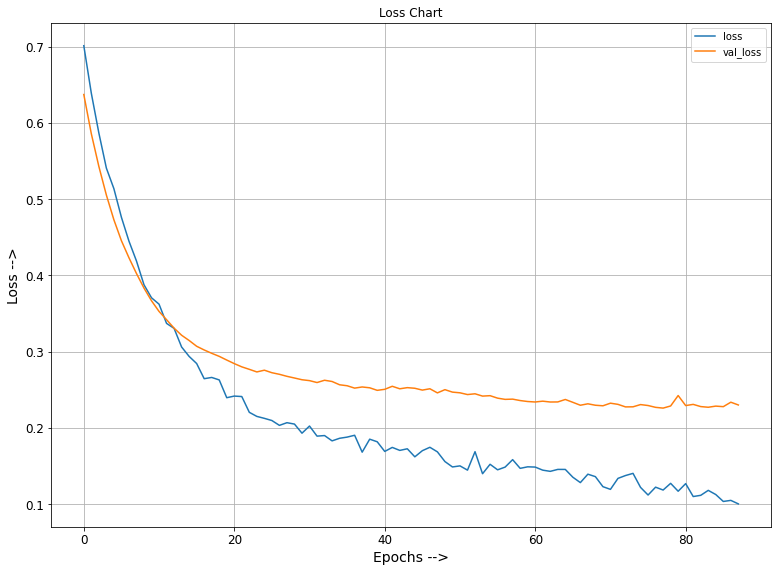

In [259]:
# plot some data
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.gca().set_position([0, 0, 1, 1])
plt.xlabel("Epochs -->")
plt.ylabel("Loss -->")
plt.title("Loss Chart")
plt.show()

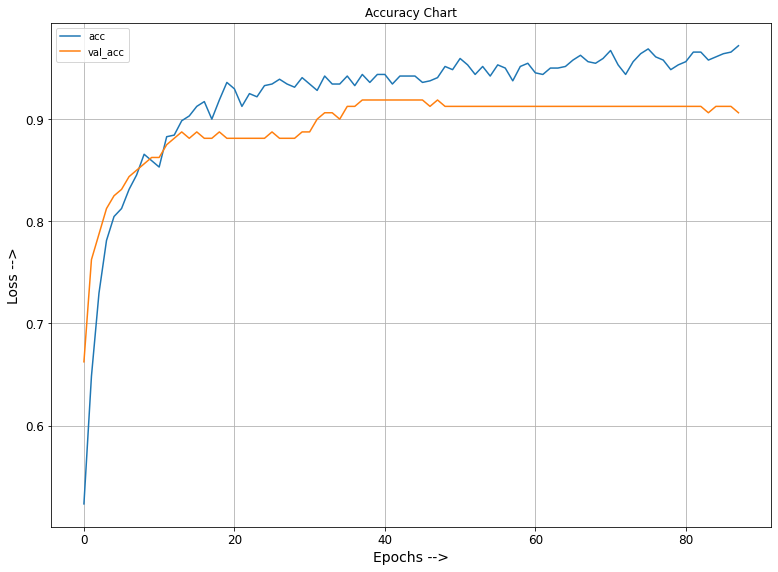

In [328]:
# accuracies
plt.figure(figsize=(10, 7))
plt.plot(history.history['accuracy'], "-", label='acc')
plt.plot(history.history['val_accuracy'], "-", label='val_acc')
plt.legend()
plt.grid()
plt.gca().set_position([0, 0, 1, 1])
plt.xlabel("Epochs -->")
plt.ylabel("Loss -->")
plt.title("Accuracy Chart")
plt.show()

In [318]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(10, 7))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.grid()
    plt.legend(fontsize=12)
    plt.xlabel("Threshold", fontsize=12)
    plt.ylabel("")
    plt.show()

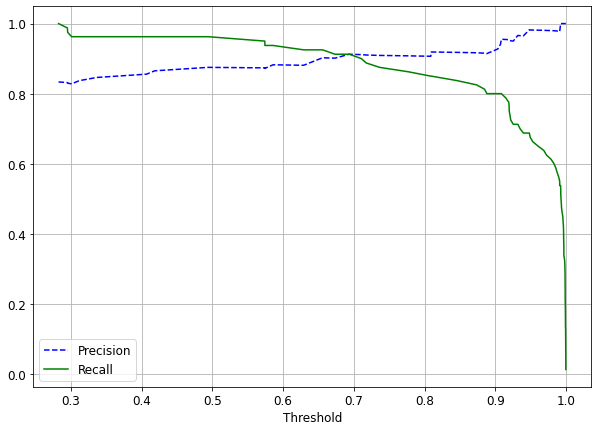

In [319]:
precisions, recalls, thresholds = precision_recall_curve(val_y, model.predict(val_X))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [305]:
threshold_equal_precision_recall = thresholds[np.argmax(precisions == recalls)]

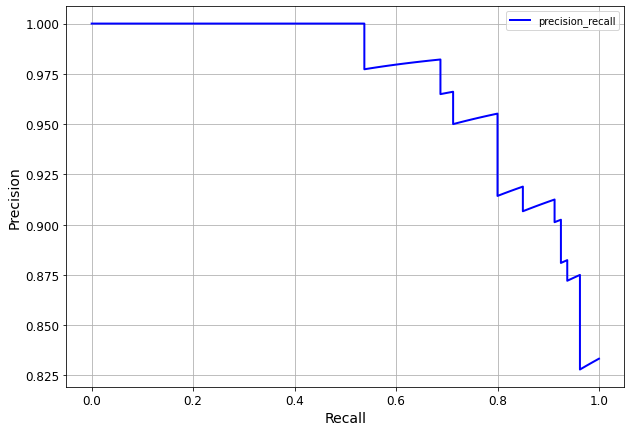

In [332]:
def plot_precision_vs_recall(precisions, recalls):
    plt.figure(figsize=(10, 7))
    plt.plot(recalls, precisions, "b-", linewidth=2, label="precision_recall")
    plt.grid()
    plt.legend()
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

plot_precision_vs_recall(precisions, recalls)

In [290]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(15, 7))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--") # Dashed Diagonal
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate (Recall)", fontsize=12)
    plt.grid()
    plt.show()

In [291]:
fpr, tpr, thresholds = roc_curve(val_y, model.predict(val_X))
fpr.shape, tpr.shape, thresholds.shape

((24,), (24,), (24,))

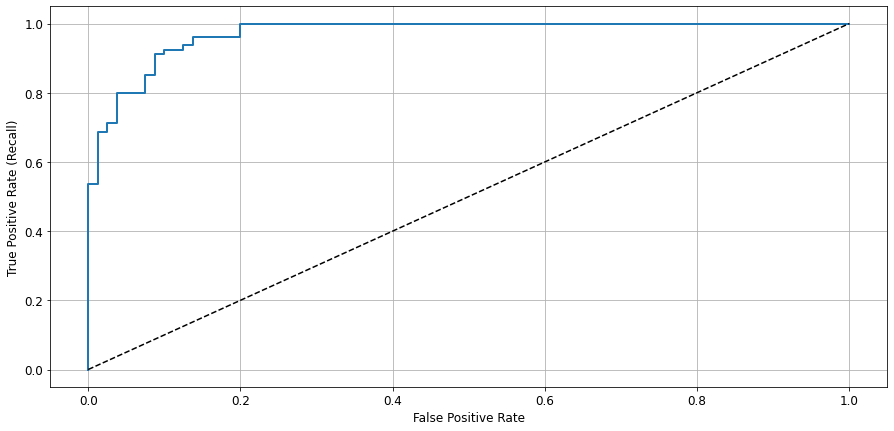

In [292]:
plot_roc_curve(fpr, tpr)

In [307]:
# For threat class only
p = model.predict(val_X)
p = np.where(p > threshold_equal_precision_recall, 1, 0)
print("Shape of predicted values : ", p.shape)
print("Shape of target values : ", val_y.shape)
tn, fp, fn, tp = confusion_matrix(val_y, p).ravel()
print("True neg : ", tn)
print("False pos : ", fp)
print("False neg : ", fn)
print("True pos : ", tp)
print()
print(classification_report(val_y, p))
print()
print("ROC : {}".format(roc_auc_score(val_y, p)))
print()
print("Precision : {}".format(precision_score(val_y, p)))
print()
print("Accuracy : {}".format(accuracy_score(val_y, p)))
print()
print("Recall : {}".format(recall_score(val_y, p)))
print()
print("F1 : {}".format(f1_score(val_y, p)))
print()

Shape of predicted values :  (160, 1)
Shape of target values :  (160, 1)
True neg :  73
False pos :  7
False neg :  8
True pos :  72

              precision    recall  f1-score   support

           0       0.90      0.91      0.91        80
           1       0.91      0.90      0.91        80

    accuracy                           0.91       160
   macro avg       0.91      0.91      0.91       160
weighted avg       0.91      0.91      0.91       160


ROC : 0.90625

Precision : 0.9113924050632911

Accuracy : 0.90625

Recall : 0.9

F1 : 0.9056603773584907



In [336]:
# save model
model.save("first_model.h5")